<ipython-input-1-2ee5d9c6d187>:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('filtered_epoch_1000.pt')
<ipython-input-1-2ee5d9c6d187>:116: Runtim

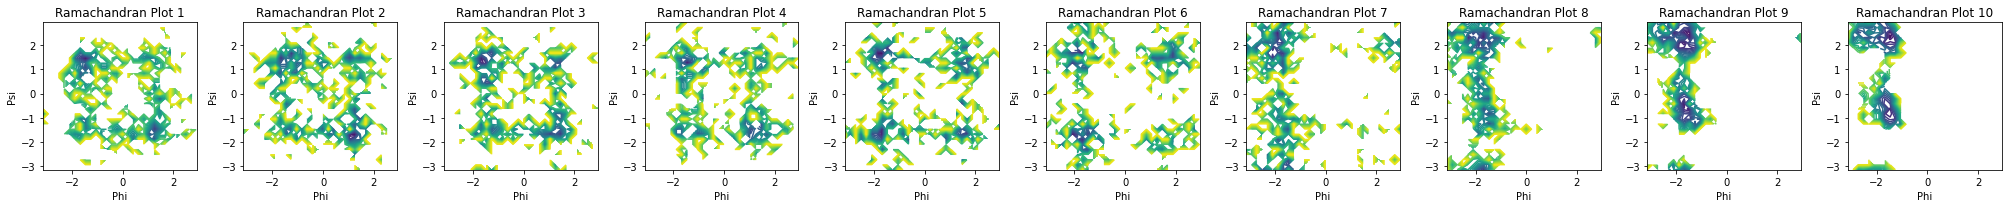

In [1]:
# Loading model
import torch
import torch.nn as nn
import torch.optim as optim
from utils import p_sample, p_sample_loop, q_sample
import MDAnalysis as mda
import matplotlib.pyplot as plt
from utils import filter_by_density
from torch.optim.lr_scheduler import CosineAnnealingLR
from utils import EMA, noise_estimation_loss, calculate_dihedral
import numpy as np
from utils import kabsch_align

class MLP(nn.Module):
    def __init__(self, n_steps, hidden_dim=512):
        super().__init__()
        
        self.n_steps = n_steps
        self.betas = self.make_beta_schedule(start=1e-5, end=1e-2)
        self.alphas = 1 - self.betas
        self.alphas_prod = torch.cumprod(self.alphas, 0)
        self.alphas_prod_p = torch.cat([torch.tensor([1]).float(), self.alphas_prod[:-1]], 0)
        self.alphas_bar_sqrt = torch.sqrt(self.alphas_prod)
        self.one_minus_alphas_bar_log = torch.log(1 - self.alphas_prod)
        self.one_minus_alphas_bar_sqrt = torch.sqrt(1 - self.alphas_prod)

        
        self.time_embed = nn.Sequential(
            nn.Embedding(n_steps, 64),
            nn.Linear(64, 64),
            nn.SiLU(),
            nn.Linear(64, 64)
        )
        
        triu_indices = torch.triu_indices(5, 5, offset=1)
        self.register_buffer('triu_i', triu_indices[0])
        self.register_buffer('triu_j', triu_indices[1])
        
        self.input_net = nn.Sequential(
            nn.Linear(30 + 64, hidden_dim),
            nn.SiLU(),
            nn.LayerNorm(hidden_dim)
        )
        
        self.middle_net = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.SiLU(),
                nn.LayerNorm(hidden_dim),
                nn.Dropout(0.1)
            ) for _ in range(6)
        ])
        
        self.final_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.LayerNorm(hidden_dim // 2),
            nn.Linear(hidden_dim // 2, 15)
        )
        
    def get_distances(self, x):
        diff_vectors = x.unsqueeze(2) - x.unsqueeze(1)  # [B, 5, 5, 3]
        distances = diff_vectors[:, self.triu_i, self.triu_j]  # [B, 10, 3]
        return distances.reshape(x.shape[0], 30)
    
    def make_beta_schedule(self, start=1e-5, end=1e-2):
        betas = torch.linspace(-6, 6, self.n_steps)
        betas = torch.sigmoid(betas) * (end - start) + start
        return betas
        
    def extract(self, input, t, x):
        shape = x.shape
        out = torch.gather(input, 0, t.to(input.device))
        reshape = [t.shape[0]] + [1] * (len(shape) - 1)
        return out.reshape(*reshape)
    
    def forward(self, x, t):
        B = x.shape[0]
        
        distances = self.get_distances(x)
        
        if t.shape[0] == 1 and B > 1:
            t = t.expand(B)
            
        t_emb = self.time_embed(t)
        features = torch.cat([distances, t_emb], dim=1)
        x = self.input_net(features)
        
        for layer in self.middle_net:
            x = x + layer(x)  # Residual connection
            
        output = self.final_net(x)
        
        return output.reshape(B, 5, 3)

model = MLP(n_steps=1000)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

checkpoint = torch.load('filtered_epoch_1000.pt')
model.load_state_dict(checkpoint['model_state_dict'])

with torch.no_grad():
    x_seq = p_sample_loop(model, shape=(1000, 5, 3))
    
    fig, axs = plt.subplots(1, 10, figsize=(28, 3))
    
    for i in range(10):
        cur_x = x_seq[i * 100].detach().cpu().numpy()
        phi_atoms = cur_x[:, :-1]
        psi_atoms = cur_x[:, 1:]
        phi = calculate_dihedral(phi_atoms)
        psi = calculate_dihedral(psi_atoms)

        H, xedges, yedges = np.histogram2d(phi, psi, bins=30, range=[[-np.pi, np.pi], [-np.pi, np.pi]])

        axs[i].contour(xedges[:-1], yedges[:-1], -np.log(H.T)+np.log(1000), levels=30, cmap='viridis')
        axs[i].set_xlabel('Phi')
        axs[i].set_ylabel('Psi')
        axs[i].set_title(f'Ramachandran Plot {i + 1}')
    
    plt.tight_layout()
    plt.show()
    plt.close(fig)

In [2]:
import MDAnalysis as mda
import matplotlib.pyplot as plt
import numpy as np

universe = mda.Universe("simulation/ala2.pdb", "simulation/md_nosol.xtc")

def process_trajectory(topology_file, trajectory_file):
    u = mda.Universe(topology_file, trajectory_file)

    heavy_atom_ids = [4, 6, 8, 14, 16]
    heavy_atoms = u.atoms[heavy_atom_ids]

    dataset = []
    for ts in u.trajectory[::5]:
        positions = heavy_atoms.positions
        com = positions.mean(axis=0)
        positions -= com  

        dataset.append(positions)

    return np.array(dataset)

topology_file = "simulation/ala2.pdb"
trajectory_file = "simulation/md_nosol.xtc"

data = process_trajectory(topology_file, trajectory_file)
data.shape

(1000001, 5, 3)

In [3]:
from utils import kabsch_align
cur_x = data

i = 0 
phi = 0.0
psi = 0.0
for state1 in cur_x:
    phi_atoms = np.array([state1[:-1]])
    psi_atoms = np.array([state1[1:]])
    phi = calculate_dihedral(phi_atoms)
    psi = calculate_dihedral(psi_atoms)
    
    if np.isclose(phi,-2.45 , rtol=0.05) & np.isclose(psi,2.45, rtol=0.05):
        break
    
print(state1)
    

i = 0 
phi = 0.0
psi = 0.0
for state2 in cur_x:
    phi_atoms = np.array([state2[:-1]])
    psi_atoms = np.array([state2[1:]])
    phi = calculate_dihedral(phi_atoms)
    psi = calculate_dihedral(psi_atoms)
    
    if np.isclose(phi, -1.45, rtol=0.05) & np.isclose(psi, -0.69, rtol=0.05):
        break

print(state2)

state1, _ = kabsch_align(state1, state2)

[[ 0.6739979  -0.12999916  2.2959976 ]
 [ 0.3540001   0.5         1.1659985 ]
 [-0.40600204 -0.17000008  0.13599968]
 [-0.19600105  0.3200016  -1.2940006 ]
 [-0.42600155 -0.51999855 -2.3040018 ]]
[[-1.4820061   1.2280006   0.27199936]
 [-0.9320049   0.11800003  0.7619972 ]
 [ 0.5079956  -0.02199936  0.8519974 ]
 [ 1.2579956  -0.33199883 -0.44800186]
 [ 0.647995   -0.9920006  -1.4380035 ]]


Converged after 2662 iterations


<ipython-input-4-7b24eb2c3e0a>:42: RuntimeWarning: divide by zero encountered in log
  ax1.contour(xedges[:-1], yedges[:-1], -np.log(H.T)+np.log(1000000), levels=10, colors='#6baed6', linewidths=2.0, linestyles='solid')


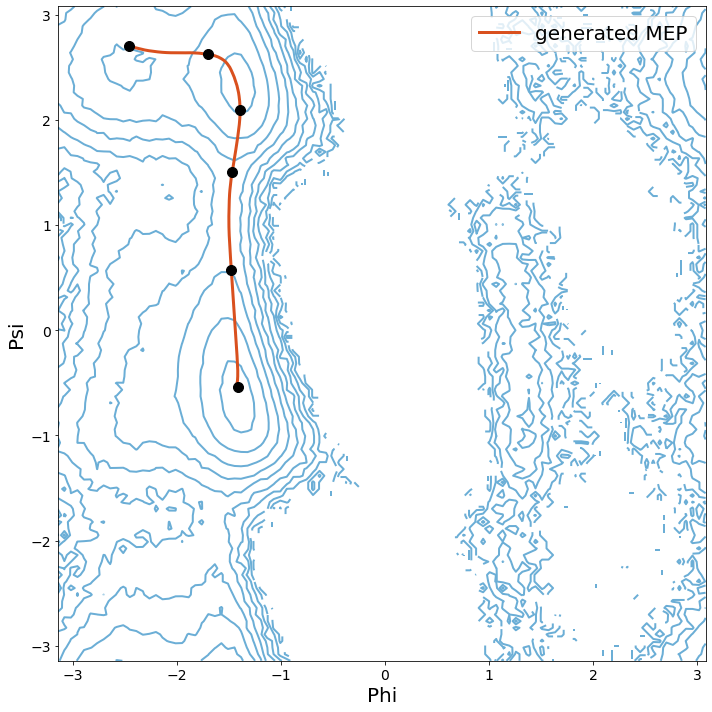

In [4]:
from stringmethod import StringMethod

def neural_ff(model, string, t):
    string_tensor = torch.tensor(string, dtype=torch.float32)
    t_tensor = torch.tensor([t], dtype=torch.long)
    
    with torch.no_grad():
        eps_theta = model(string_tensor, t_tensor)
    
    nn_force = -eps_theta / model.extract(model.one_minus_alphas_bar_sqrt, t_tensor, string_tensor)
    return nn_force.numpy()

def force_function(string):
    return neural_ff(model, string, noise_lvl)

def interpolate_states(state1, state2, num_steps):
    alpha = np.linspace(0, 1, num_steps)
    return np.array([(1-a) * state1 + a * state2 for a in alpha])


noise_lvl = 240

endpoints = np.array([state1, state2])

phi_atoms = data[:, :-1]
psi_atoms = data[:, 1:]
phi = calculate_dihedral(phi_atoms)
psi = calculate_dihedral(psi_atoms)

H, xedges, yedges = np.histogram2d(phi, psi, bins=100, range=[[-np.pi, np.pi], [-np.pi, np.pi]])

initial_string = interpolate_states(endpoints[0], endpoints[1], num_steps=200)
string_method = StringMethod(initial_string, force_function, max_iterations=5000, dt=0.00015)
final_string = string_method.equilibrate()
    
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
    
ax1.contour(xedges[:-1], yedges[:-1], -np.log(H.T)+np.log(1000000), levels=10, colors='#6baed6', linewidths=2.0, linestyles='solid')
    
phi_final = calculate_dihedral(final_string[:, :-1])
psi_final = calculate_dihedral(final_string[:, 1:])
ax1.plot(phi_final, psi_final, c="#D9501E", linewidth = 3, label = 'generated MEP', zorder = 4)
ax1.scatter(np.hstack([phi_final[::40],phi_final[-1]]), np.hstack([psi_final[::40],psi_final[-1]]), c='black', s=100, zorder = 5)

ax1.tick_params(axis='both', labelsize=14)

ax1.set_xlabel('Phi', fontsize = 20)
ax1.set_ylabel('Psi', fontsize = 20)
ax1.legend(fontsize = 20)

#plt.savefig("AD_MEP", dpi = 800)

plt.tight_layout()
plt.show()
plt.close(fig)

In [5]:
def save_trajectory_ovito(trajectory, filename="trajectory.xyz", atom_types=None):
    n_steps, n_atoms, _ = trajectory.shape
    if atom_types is None:
        atom_types = ['C'] * n_atoms
        
    with open(filename, 'w') as f:
        for step in trajectory:
            f.write(f"{n_atoms}\n")  # Number of atoms
            f.write("Frame\n")       # Comment line
            for atom_type, pos in zip(atom_types, step):
                f.write(f"{atom_type} {pos[0]:.6f} {pos[1]:.6f} {pos[2]:.6f}\n")

save_trajectory_ovito(final_string, "MEP.xyz", atom_types=['C', 'N', 'C', 'N', 'C'])